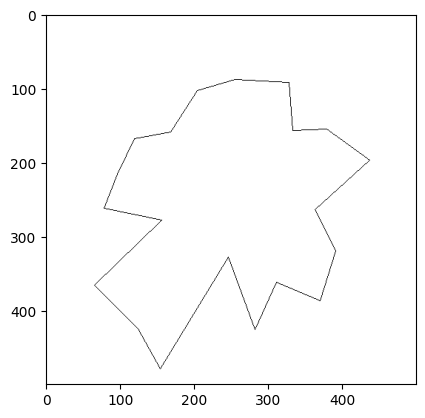

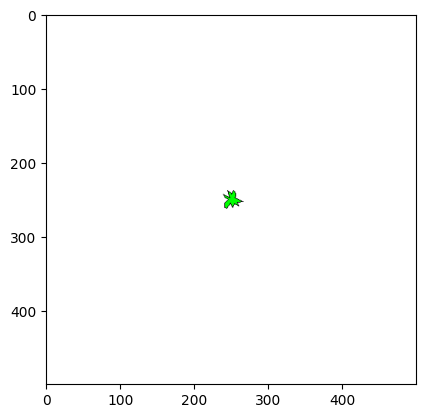

In [2]:
%run polygon.ipynb

In [3]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import enum
import copy
import random
from tqdm import tqdm

width = 500
height = 500

def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def in_polygon(x, y, polygon):
    n = len(polygon)
    inside = False

    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y

    return inside

def scale_polygon(polygon, scale):
    new_polygon = []
    for p in polygon:
        new_polygon.append((p[0] * scale, p[1] * scale))
    return new_polygon

def translate_polygon(polygon, x, y):
    new_polygon = []
    for p in polygon:
        new_polygon.append((p[0] + x, p[1] + y))
    return new_polygon

def center_on_point(polygon, x, y):
    min_x = min(polygon, key=lambda p: p[0])[0]
    min_y = min(polygon, key=lambda p: p[1])[1]
    max_x = max(polygon, key=lambda p: p[0])[0]
    max_y = max(polygon, key=lambda p: p[1])[1]
    return translate_polygon(polygon, x - (max_x + min_x) / 2, y - (max_y + min_y) / 2)

def rotate_polygon(polygon, angle):
    new_polygon = []
    for p in polygon:
        new_polygon.append((p[0] * np.cos(angle) - p[1] * np.sin(angle), p[0] * np.sin(angle) + p[1] * np.cos(angle)))
    return new_polygon

In [4]:
class Leaf:

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.reached = False

In [5]:
class Branch:

    def __init__(self, parent, position, direction, width, is_trunk=False):
        self.parent = parent
        self.position = position
        self.direction = direction
        self.length = 20
        self.width = width
        self.original_direction = direction
        self.count = 0
        self.is_trunk = is_trunk

    def next(self, decay):
        next_dir = np.multiply(self.direction, self.length)
        pos = np.add(self.position, next_dir)
        width = max(self.width * decay, 2)
        return Branch(self, pos, copy.deepcopy(self.direction), width)
    
    def reset(self):
        self.count = 0
        self.direction = copy.deepcopy(self.original_direction)


In [6]:
class Tree:

    def __init__(self, leaf_count, min_distance, max_distance, base_width, branch_decay, generation_shape):
        self.min_distance = min_distance
        self.max_distance = max_distance
        self.leave_count = leaf_count
        self.base_width = base_width
        self.branch_decay = branch_decay
        self.generation_shape = generation_shape
        self.leaves = []
        self.branches = []

        self.root = Branch(None, (width / 2, height), [0, -1], base_width, is_trunk=True)
        self.branches.append(self.root)


    def initialize(self):
        self.generate_leaves()
        self.grow_until_leaves_reached()

    
    def grow(self):
        if len(self.leaves) == 0:
            return

        for leaf in self.leaves:
            closest_branch = None
            record = np.Infinity
            for branch in self.branches:
                d = distance(branch.position, (leaf.x, leaf.y))
                if d < self.min_distance:
                    leaf.reached = True
                    closest_branch = None
                    break
                elif d > self.max_distance:
                    pass
                elif closest_branch is None or d < record:
                    closest_branch = branch
                    record = d

            if closest_branch is not None:
                new_dir = np.subtract((leaf.x, leaf.y), closest_branch.position)
                new_dir = np.divide(new_dir, np.linalg.norm(new_dir))
                closest_branch.direction = np.add(closest_branch.direction, new_dir)
                closest_branch.count += 1

        for i, branch in enumerate(self.branches):
            if branch.count > 0:
                branch.direction = np.divide(branch.direction, branch.count)
                self.branches.append(branch.next(self.branch_decay))
            self.branches[i].reset()

        for i, leaf in enumerate(self.leaves):
            if leaf.reached:
                self.leaves.pop(i)


    def grow_until_leaves_reached(self):
        current = self.root
        found = False
        while not found:
            for leaf in self.leaves:
                d = distance(current.position, (leaf.x, leaf.y))
                if d < self.max_distance:
                    found = True
                    break
            
            if not found:
                branch = current.next(self.branch_decay)
                branch.is_trunk = True
                self.branches.append(branch)
                current = branch


    def generate_leaves(self):
        while len(self.leaves) < self.leave_count:
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            if in_polygon(x, y, self.generation_shape):
                self.leaves.append(Leaf(x,y))


In [7]:
tree = Tree(
    leaf_count=200,
    min_distance=10,
    max_distance=100,
    base_width=40,
    branch_decay=0.85,
    generation_shape=vertices,
)
tree.initialize()
for i in tqdm(range(100)):
    tree.grow()

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


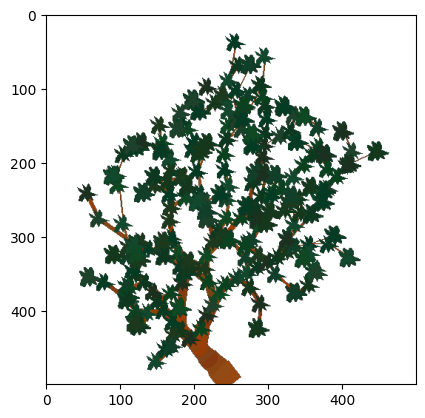

In [17]:
image = Image.new("RGBA", (width, height), (0, 0, 0, 0))
draw = ImageDraw.Draw(image)

browns = [
    (139, 69, 19, 255),
]

for i in range(10):
    browns.append((
        browns[i-1][0] + np.random.randint(-10, 10),
        browns[i-1][1] + np.random.randint(-10, 10),
        browns[i-1][2] + np.random.randint(-10, 10),
        browns[i-1][3] + np.random.randint(-10, 10),
    ))

for branch in tree.branches:
    if branch.parent is not None:
        draw.line((
            branch.position[0],
            branch.position[1],
            branch.parent.position[0],
            branch.parent.position[1]),
            fill=random.choice(browns),
            width=int(branch.width)
        )

        # draw ellipse at branch position
        draw.ellipse((
            branch.position[0]-branch.width*0.45,
            branch.position[1]-branch.width*0.45,
            branch.position[0]+branch.width*0.45,
            branch.position[1]+branch.width*0.45),
            fill=random.choice(browns)
        )

        # draw leaf_verts at branch position
        #leaf_verts = rotate_polygon(leaf_verts, np.random.uniform(0, 2*np.pi))
        #leaf_verts = translate_polygon(leaf_verts, branch.position[0], branch.position[1])

from PIL import ImageFilter, ImageChops
#image = image.filter(ImageFilter.GaussianBlur(1))
#image = ImageChops.add(image, image.filter(ImageFilter.SHARPEN))
#draw = ImageDraw.Draw(image)

greens = [
    (28, 48, 32, 255),
]
# vary leaf color
for i in range(1, 10):
    greens.append((
        greens[i-1][0] + np.random.randint(-10, 10),
        greens[i-1][1] + np.random.randint(-10, 10),
        greens[i-1][2] + np.random.randint(-10, 10),
        greens[i-1][3] + np.random.randint(-10, 10),
    ))

for branch in tree.branches:
    if branch.is_trunk:
        continue
    if branch.width >= tree.base_width*0.6:
        continue

    verts = copy.deepcopy(leaf_verts)

    #verts = rotate_polygon(verts, np.random.uniform(0, 2*np.pi))

    verts = center_on_point(
        verts,
        branch.position[0] + np.random.uniform(-1, 1),
        branch.position[1] + np.random.uniform(-1, 1)
    )

    #verts = rotate_around_center(verts, np.random.uniform(0, 2*np.pi))
    draw.polygon(verts, fill=random.choice(greens))

#draw.polygon(leaf_verts, fill=(28, 48, 32, 255))
#draw.polygon(vertices, outline=(0,0,0,255))

# blur image
#from PIL import ImageFilter, ImageChops
#image = image.filter(ImageFilter.GaussianBlur(2))
#
plt.imshow(image)

image.save("tree.png")